# Download Dataset จาก Kaggle

In [ ]:
import kagglehub
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import os

path = kagglehub.dataset_download("sriramr/fruits-fresh-and-rotten-for-classification")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'fruits-fresh-and-rotten-for-classification' dataset.
Path to dataset files: /kaggle/input/fruits-fresh-and-rotten-for-classification


# นำข้อมูลมา Transform เพื่อทำให้อยู่ใน format เพื่อให้ Model สามารถทำการ train ได้

In [ ]:
root_dir = os.path.join(path, "dataset")
train_dir = os.path.join(root_dir, "train")

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

full_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
classes = full_dataset.classes
num_classes = len(classes)
print("Classes:", classes)

train_ratio = 0.8
train_size = int(train_ratio * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(
    full_dataset, [train_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=False)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=2, pin_memory=True, persistent_workers=False)

print(f"Split sizes -> train={len(train_dataset)}, test={len(test_dataset)}")

Classes: ['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']
Split sizes -> train=8720, test=2181


# Setting up Convolution Neural Network

In [ ]:
import torch, math, time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

classes = full_dataset.classes
num_classes = len(classes)
print("Detected classes:", classes)

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, s=1, p=1, drop=0.0):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, k, s, p, bias=False)
        self.bn = nn.BatchNorm2d(out_ch)
        self.act = nn.SiLU(inplace=True)
        self.drop = nn.Dropout2d(drop) if drop > 0 else nn.Identity()
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        x = self.drop(x)
        return x

class TinyCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.stem = ConvBlock(3, 32, k=3, s=1, p=1, drop=0.05)
        self.layer1 = nn.Sequential(
            ConvBlock(32, 64, drop=0.05),
            ConvBlock(64, 64),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            ConvBlock(64, 128, drop=0.05),
            ConvBlock(128, 128),
            nn.MaxPool2d(2)
        )
        self.layer3 = nn.Sequential(
            ConvBlock(128, 256, drop=0.1),
            ConvBlock(256, 256),
            nn.MaxPool2d(2)
        )
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.SiLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.head(x)
        return x

model = TinyCNN(num_classes).to(device)
print(f"Model params: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")

Detected classes: ['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']
Model params: 1.23M


# Training Convolution Neural Network

In [ ]:
@dataclass
class TrainConfig:
    epochs:int = 15
    lr:float = 5e-3
    weight_decay:float = 1e-4
    grad_clip:float | None = 1.0
    use_amp:bool = True

cfg = TrainConfig()

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.epochs)

scaler = torch.amp.GradScaler(enabled=cfg.use_amp)

@torch.no_grad()
def evaluate(model, loader, device, criterion):
    model.eval()
    total_loss, total_correct, n = 0.0, 0, 0
    for x, y in loader:
        x = x.to(device, non_blocking=True); y = y.to(device, non_blocking=True)
        with torch.amp.autocast(device_type=device.type, enabled=cfg.use_amp):
            logits = model(x)
            loss = criterion(logits, y)
        bs = y.size(0)
        total_loss += loss.item() * bs
        total_correct += (logits.argmax(1) == y).sum().item()
        n += bs
    return total_loss / n, total_correct / n

history = {"train_loss":[], "train_acc":[], "test_loss":[], "test_acc":[]}
best_acc = 0.0
best_state = None
start_time = time.time()

for epoch in range(1, cfg.epochs+1):
    model.train()
    running_loss, running_correct, seen = 0.0, 0, 0

    for xb, yb in train_loader:
        xb = xb.to(device, non_blocking=True); yb = yb.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast(device_type=device.type, enabled=cfg.use_amp):
            logits = model(xb)
            loss = criterion(logits, yb)

        scaler.scale(loss).backward()
        if cfg.grad_clip is not None:
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)
        scaler.step(optimizer)
        scaler.update()

        bs = yb.size(0)
        running_loss += loss.item() * bs
        running_correct += (logits.argmax(1) == yb).sum().item()
        seen += bs

    train_loss = running_loss / seen
    train_acc = running_correct / seen

    test_loss, test_acc = evaluate(model, test_loader, device, criterion)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["test_loss"].append(test_loss)
    history["test_acc"].append(test_acc)

    if test_acc > best_acc:
        best_acc = test_acc
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    scheduler.step()

    print(f"Epoch: {epoch:02d} | "
          f"train_loss: {train_loss:.3f} train_acc: {train_acc:.3f} | "
          f"test_loss: {test_loss:.3f} train_acc: {test_acc:.3f} | "
          f"learning rate {scheduler.get_last_lr()[0]:.2e}")

total_time = time.time() - start_time
print(f"Done in {total_time/60:.1f} min. Best test acc = {best_acc:.3f}")

if best_state is not None:
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

Epoch: 01 | train_loss: 0.831 train_acc: 0.700 | test_loss: 0.691 train_acc: 0.720 | learning rate 4.95e-03
Epoch: 02 | train_loss: 0.551 train_acc: 0.809 | test_loss: 0.497 train_acc: 0.827 | learning rate 4.78e-03
Epoch: 03 | train_loss: 0.485 train_acc: 0.827 | test_loss: 0.485 train_acc: 0.843 | learning rate 4.52e-03
Epoch: 04 | train_loss: 0.406 train_acc: 0.856 | test_loss: 0.372 train_acc: 0.871 | learning rate 4.17e-03
Epoch: 05 | train_loss: 0.374 train_acc: 0.870 | test_loss: 0.290 train_acc: 0.892 | learning rate 3.75e-03
Epoch: 06 | train_loss: 0.330 train_acc: 0.885 | test_loss: 0.321 train_acc: 0.875 | learning rate 3.27e-03
Epoch: 07 | train_loss: 0.295 train_acc: 0.898 | test_loss: 0.192 train_acc: 0.929 | learning rate 2.76e-03
Epoch: 08 | train_loss: 0.265 train_acc: 0.906 | test_loss: 0.181 train_acc: 0.935 | learning rate 2.24e-03
Epoch: 09 | train_loss: 0.231 train_acc: 0.919 | test_loss: 0.140 train_acc: 0.944 | learning rate 1.73e-03
Epoch: 10 | train_loss: 0.21

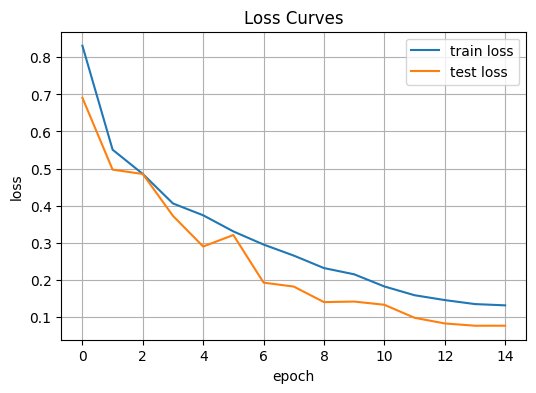

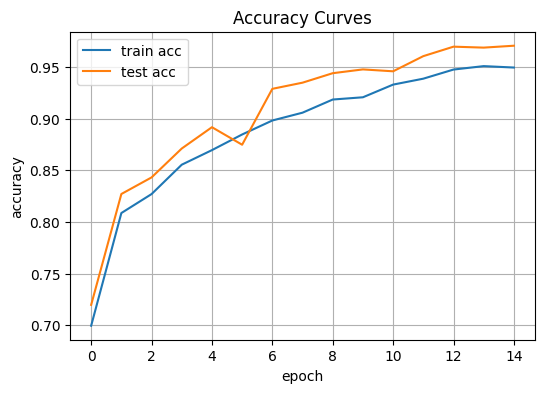

In [ ]:
@torch.no_grad()
def predict_all(model, loader, device):
    model.eval()
    ys, yhats = [], []
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        logits = model(x)
        pred = logits.argmax(1).cpu().numpy()
        yhats.append(pred)
        ys.append(y.numpy())
    return np.concatenate(ys), np.concatenate(yhats)

y_true, y_pred = predict_all(model, test_loader, device)

plt.figure(figsize=(6,4))
plt.plot(history["train_loss"], label="train loss")
plt.plot(history["test_loss"], label="test loss")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Loss Curves"); plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history["train_acc"], label="train acc")
plt.plot(history["test_acc"], label="test acc")
plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.title("Accuracy Curves"); plt.legend(); plt.grid(True)
plt.show()

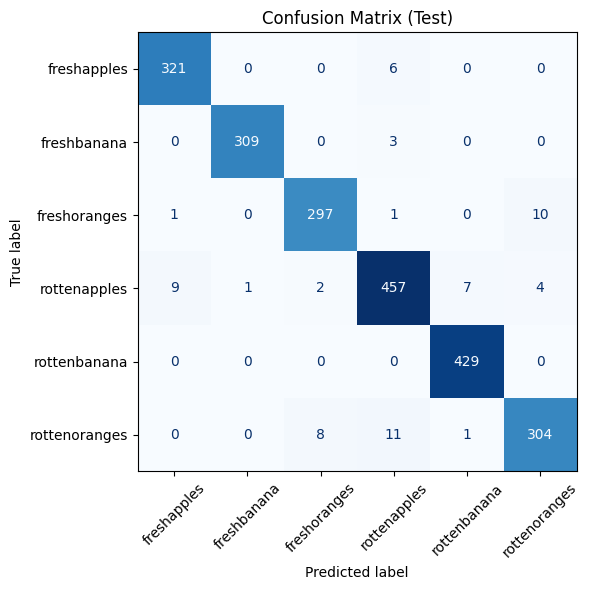

In [ ]:
# ---- Confusion Matrix ----
cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, xticks_rotation=45, values_format='d', cmap="Blues", colorbar=False)
plt.title("Confusion Matrix (Test)")
plt.tight_layout()
plt.show()

In [ ]:
cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))

TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (FP + FN + TP)

precision = TP / (TP + FP + 1e-8)
recall = TP / (TP + FN + 1e-8)

print("Per-Class Metrics:")
print(f"{'Class':<15} {'TP':>5} {'FP':>5} {'FN':>5} {'TN':>7} {'Precision':>12} {'Recall':>10}")
for i, cls in enumerate(classes):
    print(f"{cls:<15} {TP[i]:5d} {FP[i]:5d} {FN[i]:5d} {TN[i]:7d} {precision[i]:12.3f} {recall[i]:10.3f}")

macro_precision = np.mean(precision)
macro_recall = np.mean(recall)
print("\nMacro Precision:", macro_precision)
print("Macro Recall:", macro_recall)

print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=classes))


Per-Class Metrics:
Class              TP    FP    FN      TN    Precision     Recall
freshapples       321    10     6    1844        0.970      0.982
freshbanana       309     1     3    1868        0.997      0.990
freshoranges      297    10    12    1862        0.967      0.961
rottenapples      457    21    23    1680        0.956      0.952
rottenbanana      429     8     0    1744        0.982      1.000
rottenoranges     304    14    20    1843        0.956      0.938

Macro Precision: 0.9712874292227434
Macro Recall: 0.9705926630302876

Classification Report:
                precision    recall  f1-score   support

  freshapples       0.97      0.98      0.98       327
  freshbanana       1.00      0.99      0.99       312
 freshoranges       0.97      0.96      0.96       309
 rottenapples       0.96      0.95      0.95       480
 rottenbanana       0.98      1.00      0.99       429
rottenoranges       0.96      0.94      0.95       324

     accuracy                        